# Necessary Imports
In this section, we will import the necessary libraries for training our Convolutional Neural Network (CNN) model. This includes libraries for data manipulation, model building, and evaluation.

In [2]:
# system and utility imports
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib

# sklearn metrics and utilities
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, accuracy_score, confusion_matrix, 
    classification_report, auc, log_loss, precision_score, 
    recall_score, f1_score
)
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

# tensorFlow and keras model utilities
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# tensorFlow and keras layers
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, 
    Conv2DTranspose, Activation, LeakyReLU, UpSampling2D, 
    Conv2D, MaxPooling2D, ReLU
)

# image preprocessing
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

# regularization
from keras.regularizers import l2

# Image Loading and Preprocessing Functions
We shall create several functions for loading and preprocessing images from a specified directory. The functions perform the following tasks:

1. **Check if a file is an image:** A helper function that determines if a given filename has an image file extension (specifically `.jpg`).

2. **Load and preprocess an image:** A function that loads an image from a specified path, resizes it to a target size (defaulting to 128x128 pixels), normalizes pixel values to be between 0 and 1, and ensures that the image has three color channels (RGB).

3. **Load images from a directory:** A function that walks through a specified directory, loads and preprocesses images, and assigns them a label (either fraudulent or non-fraudulent) based on the provided input.

4. **Set base directory and load training images:** The base directory for the dataset is specified, along with paths to the training data subdirectories for fraudulent and non-fraudulent images. The training images are then loaded and labeled accordingly.

In [4]:
# function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith('.jpg')

In [5]:
# function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # load image
    image = Image.open(img_path)
    
    # resize image to target size
    image = image.resize(target_size)
    
    # convert image to array and normalize (pixel values between 0 and 1)
    image = np.array(image) / 255.0
    
    # ensure image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # If RGBA, convert to RGB
        image = image[:, :, :3]
    
    return image

In [6]:
# function to load images from a directory and assign labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                img_path = os.path.join(root, file)
                image = load_and_preprocess_image(img_path)  # Load and preprocess
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [7]:
# base directory for the dataset
directory = 'vehicle_insurance_dataset'

# set paths for training data subdirectories
train_fraud_dir = os.path.join(directory, 'train', 'fraud')
train_non_fraud_dir = os.path.join(directory, 'train', 'non-fraud')

# load and label the training images for fraud and non-fraud cases
train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images (fraud) shape: {train_images_fraud.shape}")
print(f"Train labels (fraud) shape: {train_labels_fraud.shape}")
print(f"Train images (non-fraud) shape: {train_images_non_fraud.shape}")
print(f"Train labels (non-fraud) shape: {train_labels_non_fraud.shape}")

Train images (fraud) shape: (372, 128, 128, 3)
Train labels (fraud) shape: (372,)
Train images (non-fraud) shape: (6091, 128, 128, 3)
Train labels (non-fraud) shape: (6091,)


# Reshape the Image Data for SMOTE
To apply Synthetic Minority Over-sampling Technique (SMOTE) to image data, we need to first reshape the images into a flat format. This process involves:

1. **Flattening Fraud and Non-Fraud Images:**  
   Both fraud and non-fraud images are reshaped into two-dimensional arrays, where each image is represented as a single vector of pixel values.

2. **Creating Labels:**  
   Labels are assigned to the images: `1` for fraud and `0` for non-fraud.

3. **Combining Data:**  
   The flattened fraud and non-fraud images are combined into one dataset. Similarly, the corresponding labels are also combined.

This reshaped dataset is now ready for SMOTE, which will help in addressing class imbalance by synthetically generating new fraud examples.

In [9]:
# reshape the image data for SMOTE
fraud_images_flat = train_images_fraud.reshape(train_images_fraud.shape[0], -1)
non_fraud_images_flat = train_images_non_fraud.reshape(train_images_non_fraud.shape[0], -1)

# create labels for fraud (1) and non-fraud (0)
fraud_labels = np.ones(train_images_fraud.shape[0])
non_fraud_labels = np.zeros(train_images_non_fraud.shape[0])

# combine images and labels
smote_cnn_combined_images_flat = np.vstack((fraud_images_flat, non_fraud_images_flat))
smote_cnn_combined_labels = np.hstack((fraud_labels, non_fraud_labels))

# Load the SMOTE Model from a File Using Joblib
In this step, we load a previously saved SMOTE model (from data pre-processing step) from a file using the `joblib` library. Loading the model allows us to reuse the pre-trained SMOTE model without having to train it again.

- **Purpose:**  
  To load the SMOTE model that was previously saved in the file `'smote_model.pkl'`.

- **Benefit:**  
  This saves time and computational resources by avoiding retraining and directly utilizing the pre-trained model for generating synthetic samples.

In [11]:
# load the SMOTE model from the file using joblib
smote_cnn_smote_loaded = joblib.load('smote_model.pkl')

# print the loaded model's class name and parameters
print(f"Loaded model: {smote_cnn_smote_loaded.__class__.__name__}")
print(f"Model parameters: {smote_cnn_smote_loaded.get_params()}")

Loaded model: SMOTE
Model parameters: {'k_neighbors': 5, 'n_jobs': None, 'random_state': None, 'sampling_strategy': 'auto'}


# Apply SMOTE to Oversample the Fraud Class in the Training Data
In this step, we apply the loaded SMOTE model to oversample the fraud class in our training dataset. The process includes the following steps:

1. **Resample the Data:**  
   SMOTE is applied to the flattened image data (`smote_cnn_combined_images_flat`) and corresponding labels (`smote_cnn_combined_labels`). This generates synthetic examples for the minority class (fraud), resulting in a balanced dataset.

2. **Separate Resampled Fraud and Non-Fraud Images:**  
   The resampled data is split back into fraud and non-fraud images based on their labels.

3. **Reshape Resampled Images:**  
   The flattened resampled fraud and non-fraud images are reshaped back into their original image dimensions (height, width, and channels).

4. **Combine Resampled Fraud and Non-Fraud Images:**  
   The resampled fraud images are combined with the original non-fraud images to form the final balanced training set.

5. **Check the Balanced Dataset:**  
   The shapes of the balanced images and labels are displayed to ensure that the dataset is correctly balanced, with equal representation of fraud and non-fraud examples.

In [13]:
# apply SMOTE to oversample the fraud class in the training data
X_resampled_smote_cnn, y_resampled_smote_cnn = smote_cnn_smote_loaded.fit_resample(smote_cnn_combined_images_flat, smote_cnn_combined_labels)

# separate resampled fraud and non-fraud images
X_fraud_resampled_smote_cnn = X_resampled_smote_cnn[y_resampled_smote_cnn == 1]
X_non_fraud_resampled_smote_cnn = X_resampled_smote_cnn[y_resampled_smote_cnn == 0]

# reshape the resampled fraud images and the original non-fraud images back into the image shape
image_height_smote_cnn, image_width_smote_cnn, image_channels_smote_cnn = train_images_fraud.shape[1], train_images_fraud.shape[2], train_images_fraud.shape[3]
X_fraud_resampled_images_smote_cnn = X_fraud_resampled_smote_cnn.reshape(-1, image_height_smote_cnn, image_width_smote_cnn, image_channels_smote_cnn)
X_non_fraud_resampled_images_smote_cnn = X_non_fraud_resampled_smote_cnn.reshape(-1, image_height_smote_cnn, image_width_smote_cnn, image_channels_smote_cnn)

# combine resampled fraud images and non-fraud images
X_train_balanced_smote_cnn = np.vstack((X_fraud_resampled_images_smote_cnn, X_non_fraud_resampled_images_smote_cnn))
y_train_balanced_smote_cnn = np.hstack((np.ones(X_fraud_resampled_images_smote_cnn.shape[0]), np.zeros(X_non_fraud_resampled_images_smote_cnn.shape[0])))

# display the shapes of the balanced data
print(f"Balanced train images shape: {X_train_balanced_smote_cnn.shape}")
print(f"Balanced train labels shape: {y_train_balanced_smote_cnn.shape}")


Balanced train images shape: (12182, 128, 128, 3)
Balanced train labels shape: (12182,)


# Denoising Function
We will create a function to load the saved denoising model for processing images using a Deep Convolutional Autoencoder (DCAE). The function performs the following tasks:

1. **Load the DCAE model:** The model is loaded from a specified path to be used for denoising the images.

2. **Denoise fraud and non-fraud images:** The function uses the loaded DCAE model to predict and denoise both fraudulent and non-fraudulent images.

3. **Print shapes of the denoised datasets:** The shapes of the resulting denoised image arrays for both the fraud and non-fraud datasets are printed to provide insight into the transformation.

The function then returns the denoised images for both categories, which can be further utilized in model training or evaluation.

In [15]:
# function to denoise
def denoise_images_with_dcae(fraud_images, non_fraud_images, dcae_model_path):
    # load the DCAE model for denoising
    dcae_model = load_model(dcae_model_path)
    print("DCAE model loaded.")

    # denoising fraud and non-fraud images
    fraud_images_denoised = dcae_model.predict(fraud_images)
    non_fraud_images_denoised = dcae_model.predict(non_fraud_images)

    # print the shape of the denoised datasets
    print(f"Denoised Fraud dataset shape: {fraud_images_denoised.shape}")
    print(f"Denoised Non-Fraud dataset shape: {non_fraud_images_denoised.shape}")

    return fraud_images_denoised, non_fraud_images_denoised

# Denoise the Balanced Fraud and Non-Fraud Images
This step applies a pre-trained Deep Convolutional Autoencoder (DCAE) model to denoise both fraud and non-fraud images in the balanced dataset. The process involves:

1. **Denoising Fraud Images:**  
   The combined set of original and SMOTE-generated fraud images is passed through the DCAE model to remove noise and improve image quality.

2. **Denoising Non-Fraud Images:**  
   The original non-fraud images from the training data are also denoised using the same DCAE model.

3. **Using a Pre-Trained DCAE Model:**  
   The DCAE model is loaded from the specified path (`'dcae_model.keras'`) and applied to both sets of images, producing cleaner versions of the fraud and non-fraud images.

By denoising the images, we aim to improve the performance of subsequent models trained on this dataset.

In [17]:
# denoise the balanced fraud and non-fraud images
fraud_images_denoised_smote_cnn, non_fraud_images_denoised_smote_cnn = denoise_images_with_dcae(
    X_fraud_resampled_images_smote_cnn,  # combined original + SMOTE-generated fraud images
    X_non_fraud_resampled_images_smote_cnn,  # original non-fraud images from the training data
    'dcae_model.keras'  # DCAE model path
)

DCAE model loaded.
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step
Denoised Fraud dataset shape: (6091, 128, 128, 3)
Denoised Non-Fraud dataset shape: (6091, 128, 128, 3)


# Combine Denoised Fraud and Non-Fraud Images
In this step, we combine the denoised fraud and non-fraud images into a single balanced dataset. The process includes the following:

1. **Combine Denoised Fraud and Non-Fraud Images:**  
   The denoised fraud images (both original and SMOTE-generated) are combined with the denoised non-fraud images to form the complete training dataset.

2. **Generate Labels for Fraud and Non-Fraud Classes:**  
   Labels are created for the combined dataset, where fraud images are labeled as 1 and non-fraud images as 0. The labels correspond to the images in the same order.

3. **Shuffle Images and Labels:**  
   The dataset is shuffled to ensure randomness. Both the denoised images and corresponding labels are shuffled together using the same indices, maintaining label-image alignment.

4. **Verify Dataset Shape:**  
   Finally, the shapes of the combined and shuffled images and labels are displayed to confirm that the dataset has been correctly formed and balanced.

This step ensures that the denoised dataset is ready for training with equal representation of fraud and non-fraud examples, in a randomized order.

In [19]:
# combine denoised fraud and non-fraud images
balanced_images_denoised_smote_cnn = np.vstack((fraud_images_denoised_smote_cnn, non_fraud_images_denoised_smote_cnn))

# combine labels for fraud (1) and non-fraud (0) as they were defined earlier
balanced_train_labels_denoised_smote_cnn = np.hstack((np.ones(fraud_images_denoised_smote_cnn.shape[0]), np.zeros(non_fraud_images_denoised_smote_cnn.shape[0])))

# shuffle both images and labels together
indices = np.arange(balanced_images_denoised_smote_cnn.shape[0])
np.random.shuffle(indices)

balanced_images_denoised_smote_cnn = balanced_images_denoised_smote_cnn[indices]
balanced_train_labels_denoised_smote_cnn = balanced_train_labels_denoised_smote_cnn[indices]

# verify the shape of the shuffled and combined datasets
print(f"Combined Fraud & Non-Fraud train dataset shape: {balanced_images_denoised_smote_cnn.shape}")
print(f"Combined Fraud & Non-Fraud train label dataset shape: {balanced_train_labels_denoised_smote_cnn.shape}")

Combined Fraud & Non-Fraud train dataset shape: (12182, 128, 128, 3)
Combined Fraud & Non-Fraud train label dataset shape: (12182,)


# Building the Classification Model
Here we define a function to build a Convolutional Neural Network (CNN) for image classification. The model is designed to classify images into two categories: fraud and non-fraud. The architecture includes several convolutional and pooling layers, followed by dense layers for classification.

### Model Architecture
1. **Input Layer:** The model takes images of shape `(128, 128, 3)` as input, which corresponds to the height, width, and number of color channels (RGB).

2. **Convolutional Layers:** 
   - Three convolutional layers are added, each followed by a max pooling layer to reduce the spatial dimensions.
   - Each convolutional layer uses ReLU activation and includes L2 regularization to mitigate overfitting.

3. **Flatten Layer:** The output from the last convolutional layer is flattened to prepare it for the dense layers.

4. **Dense Layers:** 
   - A dense layer with 128 units and ReLU activation is added, followed by dropout to prevent overfitting.
   - The final output layer uses a sigmoid activation function for binary classification.

### Model Compilation
The model is compiled with the Adam optimizer, set to a lower learning rate of `0.0001`, using binary cross-entropy as the loss function and accuracy as the evaluation metric.

In [21]:
def build_classification_model(input_shape):
    model = Sequential([
        Input(shape=input_shape), 
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)), 
        Dropout(0.5),  
        Dense(1, activation='sigmoid')
    ])
    return model

# define input shape of images
input_shape = (128, 128, 3)

# create the model
model_smote_cnn = build_classification_model(input_shape)

# compile the model with a lower learning rate
model_smote_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Stratified Sampling for Class Distribution
To ensure that the class distribution is maintained in both the training and validation datasets, we perform stratified sampling using the `train_test_split` function. This is particularly important for imbalanced datasets, as it helps prevent skewed class distributions that could negatively impact model training and evaluation.

### Code Explanation
1. **Stratified Splitting:** 
   - We split the balanced images and labels into training and validation sets with 80% of the data used for training and 20% for validation.
   - The `stratify` parameter is set to the original balanced training labels to ensure that both classes are represented in the same proportions as in the entire dataset.

2. **Shape Checking:**
   - We print the shapes of the training and validation datasets for both images and labels to verify the split.

3. **Class Distribution Check:** 
   - We use `np.unique` to count the occurrences of each class in both the training and validation sets.
   - Finally, we print the class distributions for both sets to ensure they are balanced.

In [23]:
# perform stratified sampling to maintain class distribution
X_train_smote_cnn, X_val_smote_cnn, y_train_smote_cnn, y_val_smote_cnn = train_test_split(
    balanced_images_denoised_smote_cnn, balanced_train_labels_denoised_smote_cnn, 
    test_size=0.2, random_state=42, 
    stratify=balanced_train_labels_denoised_smote_cnn  # stratify based on labels to maintain class distribution
)

# check the shape of the training and validation datasets
print(f"Training set shape (images): {X_train_smote_cnn.shape}")
print(f"Validation set shape (images): {X_val_smote_cnn.shape}")
print(f"Training set shape (labels): {y_train_smote_cnn.shape}")
print(f"Validation set shape (labels): {y_val_smote_cnn.shape}")

# check the class distribution in both training and validation sets
unique_train_smote_cnn, counts_train_smote_cnn = np.unique(y_train_smote_cnn, return_counts=True)
unique_val_smote_cnn, counts_val_smote_cnn = np.unique(y_val_smote_cnn, return_counts=True)

print(f"Training set class distribution: {dict(zip(unique_train_smote_cnn, counts_train_smote_cnn))}")
print(f"Validation set class distribution: {dict(zip(unique_val_smote_cnn, counts_val_smote_cnn))}")

Training set shape (images): (9745, 128, 128, 3)
Validation set shape (images): (2437, 128, 128, 3)
Training set shape (labels): (9745,)
Validation set shape (labels): (2437,)
Training set class distribution: {0.0: 4872, 1.0: 4873}
Validation set class distribution: {0.0: 1219, 1.0: 1218}


# Model Training with Callbacks and Class Weights
We implement early stopping, model checkpointing, and learning rate scheduling to enhance the training process of our CNN model. These strategies help in preventing overfitting, ensuring that the best model is saved, and adjusting the learning rate dynamically.

### Callbacks Used:
1. **EarlyStopping:** Monitors validation loss and stops training if it doesn't improve for a specified number of epochs (`patience`), restoring the best weights.
2. **ModelCheckpoint:** Saves the best model based on validation accuracy, ensuring we retain the most effective version of our model.
3. **ReduceLROnPlateau:** Adjusts the learning rate when the validation loss plateaus, promoting better convergence.

### Class Weights:
To address class imbalance, we calculate class weights using the original balanced dataset. The weight for the fraud class (class 1) is manually increased to give it more importance during training.

### Model Training:
We train the CNN model using the specified callbacks and class weights to handle the imbalance, ensuring that both classes are appropriately represented during the training process.

### Model Saving and Evaluation:
After training, the model is saved for future use, and its performance is evaluated on the validation set to determine the accuracy achieved. We finish training by analysing the model summary and visualizing the model loss and the training performance. 

In [25]:
# early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('smote_cnn_best_model.keras', monitor='val_accuracy', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# calculate class weights based on the original balanced data
class_weights_smote_cnn = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(balanced_train_labels_denoised_smote_cnn), 
    y=balanced_train_labels_denoised_smote_cnn
)
class_weights_dict_smote_cnn = dict(enumerate(class_weights_smote_cnn))

# manually adjust the weight for class 1 (fraud)
class_weights_dict_smote_cnn[1] *= 1.0  # increase weight of class 1 (fraud)
print(f"Adjusted Class Weights: {class_weights_dict_smote_cnn}")

# train the CNN model with class weights to handle imbalance
history_smote_cnn = model_smote_cnn.fit(
    balanced_images_denoised_smote_cnn, balanced_train_labels_denoised_smote_cnn, 
    validation_data=(X_val_smote_cnn, y_val_smote_cnn),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    class_weight=class_weights_dict_smote_cnn,
    verbose=1
)

# Save the model after training
print("Saving the model as smote_cnn_model_classification.keras...")
model_smote_cnn.save('smote_cnn_model_classification.keras')

# Evaluate the model
loss_smote_cnn, accuracy_smote_cnn = model_smote_cnn.evaluate(X_val_smote_cnn, y_val_smote_cnn)
print(f'Validation Accuracy: {accuracy_smote_cnn * 100:.2f}%')


Adjusted Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.5709 - loss: 2.6785 - val_accuracy: 0.6779 - val_loss: 1.0828 - learning_rate: 1.0000e-04
Epoch 2/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.7161 - loss: 0.9879 - val_accuracy: 0.7965 - val_loss: 0.7821 - learning_rate: 1.0000e-04
Epoch 3/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.8047 - loss: 0.7622 - val_accuracy: 0.8662 - val_loss: 0.6664 - learning_rate: 1.0000e-04
Epoch 4/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.8632 - loss: 0.6510 - val_accuracy: 0.9192 - val_loss: 0.5435 - learning_rate: 1.0000e-04
Epoch 5/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.9083 - loss: 0.5555 - val_accuracy: 0.9610 - val_loss: 0.4685 - learning_rate: 1.0000e-04
Epoch 6/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.9352 - loss: 0.5067 - val_accuracy: 0.9741 - val_loss: 0.4142 - learning_rate: 1.0000e-04
Epoch

In [26]:
# print the model summary
model_smote_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,914,309 (37.82 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,540 (25.21 MB)

In [27]:
# predict on the validation set
y_pred_val_smote_cnn = model_smote_cnn.predict(X_val_smote_cnn)

# convert predictions to binary labels using a threshold of 0.5
y_pred_val_binary_smote_cnn = (y_pred_val_smote_cnn > 0.5).astype("int32")

# evaluate precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_val_smote_cnn, y_pred_val_binary_smote_cnn))

# compute AUC
auc_val = roc_auc_score(y_val_smote_cnn, y_pred_val_smote_cnn)
print(f'AUC Score (Validation): {auc_val:.2f}')

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1219
         1.0       1.00      1.00      1.00      1218

    accuracy                           1.00      2437
   macro avg       1.00      1.00      1.00      2437
weighted avg       1.00      1.00      1.00      2437

AUC Score (Validation): 1.00


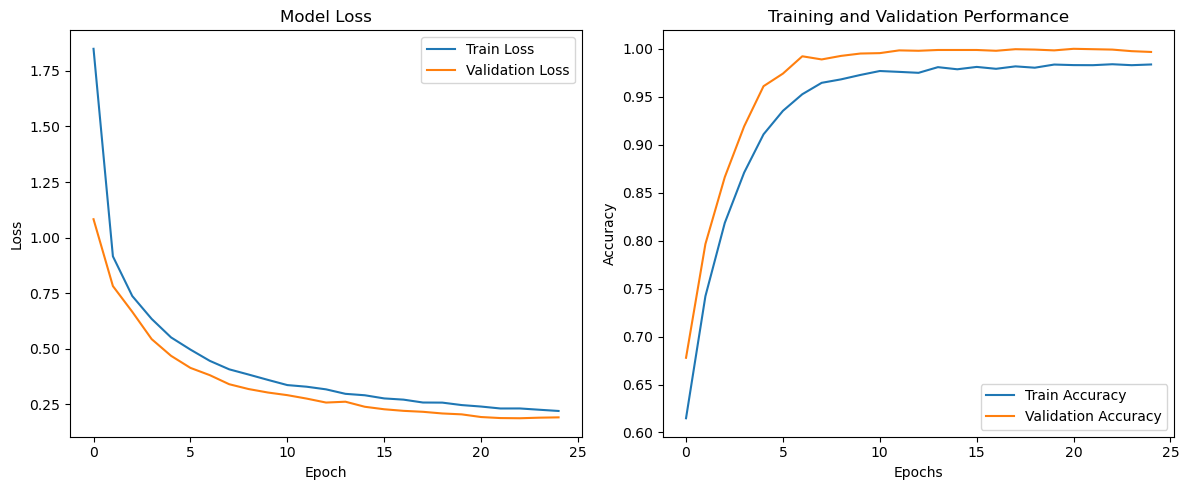

In [28]:
# create a figure for the loss plot
plt.figure(figsize=(12, 5))

# plot training & validation loss values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history_smote_cnn.history['loss'], label='Train Loss')
plt.plot(history_smote_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history_smote_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_smote_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Performance')

# show the combined plots
plt.tight_layout()  
plt.show()

# Loading Test Images and Labels
Here we define the paths to the test directories containing the fraud and non-fraud images. We then load and label the test images using the `load_images_from_directory` function, which retrieves the images from the specified directories and assigns the corresponding labels (1 for fraud and 0 for non-fraud).

### Test Directory Paths:
- **Fraud Images:** Path to the directory containing test fraud images.
- **Non-Fraud Images:** Path to the directory containing test non-fraud images.

In [30]:
# set paths to the test directories
test_fraud_dir = os.path.join(directory, 'test','fraud')
test_non_fraud_dir = os.path.join(directory,'test', 'non-fraud')

# load and label the test images
test_images_fraud_smote_cnn, test_labels_fraud_smote_cnn = load_images_from_directory(test_fraud_dir, 1)
test_images_non_fraud_smote_cnn, test_labels_non_fraud_smote_cnn = load_images_from_directory(test_non_fraud_dir, 0)

print(f"Test images fraud shape: {test_images_fraud_smote_cnn.shape}")
print(f"Test fraud labels shape: {test_labels_fraud_smote_cnn.shape}")

print(f"Test images non_fraud shape: {test_images_non_fraud_smote_cnn.shape}")
print(f"Test non_fraud labels shape: {test_labels_non_fraud_smote_cnn.shape}")

Test images fraud shape: (93, 128, 128, 3)
Test fraud labels shape: (93,)
Test images non_fraud shape: (1523, 128, 128, 3)
Test non_fraud labels shape: (1523,)


# Combining and Shuffling Test Images and Labels
In this step, we combine the test images and labels from both the fraud and non-fraud categories into single arrays. This ensures that we have a unified dataset for testing the model. 

### Steps:
1. **Concatenate Test Images and Labels:** The fraud and non-fraud images and their respective labels are concatenated along the first axis.
2. **Shuffle the Data:** To prevent any bias during testing, we generate an array of indices representing the sample positions and shuffle these indices randomly.
3. **Reorder Images and Labels:** The images and labels are reordered based on the shuffled indices to ensure a randomized test set.

In [32]:
# combine the test images and labels and shuffle
test_images_smote_cnn = np.concatenate((test_images_fraud_smote_cnn, test_images_non_fraud_smote_cnn), axis=0)
test_labels_smote_cnn = np.concatenate((test_labels_fraud_smote_cnn, test_labels_non_fraud_smote_cnn), axis=0)

# shuffle the test data rabdomly to prevent bias durign testing
indices = np.arange(test_images_smote_cnn.shape[0]) # generate an array of indices representing the positions of the samples
np.random.shuffle(indices) # shuffle the indices randomly

# reorder the images and labels according to the shuffled indices
test_images_smote_cnn = test_images_smote_cnn[indices]
test_labels_smote_cnn = test_labels_smote_cnn[indices]

print(f"Combined test images: {test_images_smote_cnn.shape}")
print(f"Combined test labels: {test_labels_smote_cnn.shape}")

Combined test images: (1616, 128, 128, 3)
Combined test labels: (1616,)


# Reshaping Test Images and Denoising
This part, we prepare the test images for evaluation by reshaping them to include the channels dimension. This is crucial for ensuring that the images are in the correct format for processing by the model.

### Steps:
1. **Reshape Test Images:** The test images are reshaped to have a shape of `(-1, 128, 128, 3)`, where `-1` automatically adjusts the number of samples based on the total number of images.
2. **Verify Shapes:** We print the shapes of the reshaped test images and the corresponding labels to ensure they are as expected.
3. **Load DCAE Model:** We load the pre-trained Deep Convolutional Autoencoder (DCAE) model to perform image denoising.
4. **Denoise Test Images:** The reshaped test images are passed through the DCAE model to produce denoised test images.

In [34]:
# now reshape to add the channels dimension
test_images_reshaped_smote_cnn = test_images_smote_cnn.reshape((-1, 128, 128, 3))

# verify the shape of the validation images and labels
print(f"Test Validation Images Shape: {test_images_reshaped_smote_cnn.shape}")
print(f"Predicted Labels Shape: {test_labels_smote_cnn.shape}")

# load the pre-trained DCAE model for denoising
dcae_model = load_model('dcae_model.keras')

# denoise the test images using the DCAE model
denoised_test_images_smote_cnn = dcae_model.predict(test_images_reshaped_smote_cnn)

# verify the shape of the denoised images
print(f"Denoised Test Images Shape: {denoised_test_images_smote_cnn.shape}")

Test Validation Images Shape: (1616, 128, 128, 3)
Predicted Labels Shape: (1616,)
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step
Denoised Test Images Shape: (1616, 128, 128, 3)


# Loading the Classification Model and Making Predictions
We load the pre-trained classification model and use it to make predictions on the denoised test images.

### Steps:
1. **Load the Model:** The classification model, saved as `smote_cnn_best_model.keras`, is loaded successfully.
2. **Check Input Shape:** We print the shape of the denoised test images to ensure it matches the model's expected input shape.
3. **Predict Probabilities:** The loaded model is used to predict probabilities for the denoised test images.
4. **Print Predicted Probabilities Shape:** Finally, we print the shape of the predicted probabilities to verify the output from the model.

In [36]:
# load the classification model
model_smote_cnn = 'smote_cnn_best_model.keras'
smote_cnn_test_classification_model = load_model(model_smote_cnn) 
print(f"Model '{model_smote_cnn}' loaded successfully.")

# ensure the input shape of denoised images matches the model's expected input
print(f"Denoised Test Images Shape (before prediction): {denoised_test_images_smote_cnn.shape}")

# predict probabilities using the denoised test images
test_probs_smote_cnn = smote_cnn_test_classification_model.predict(denoised_test_images_smote_cnn)

# print the shape of predicted probabilities
print(f"Predicted Probabilities Shape: {test_probs_smote_cnn.shape}")


Model 'smote_cnn_best_model.keras' loaded successfully.
Denoised Test Images Shape (before prediction): (1616, 128, 128, 3)
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Predicted Probabilities Shape: (1616, 1)


# Model Evaluation and Performance Visualization
In this section, we evaluate our classification model's performance using various metrics and visualize the results through ROC and Precision-Recall curves.

### Function Definitions:
1. **`plot_confusion_matrix(conf_matrix)`**:
   - Visualizes the confusion matrix as a heatmap, showing the true labels against the predicted labels for 'Fraud' and 'Non-Fraud' cases.

2. **`evaluate_model(model, model_name, test_images, test_labels, threshold=0.5)`**:
   - Evaluates the classification model on the provided test images and labels.
   - Calculates performance metrics, including accuracy, precision, recall, F1 score, area under the ROC curve (AUC), and average precision (AP).
   - Prints the calculated metrics and visualizes the confusion matrix.

### ROC Curve and AUC Calculation:
- The ROC curve is calculated using the model's predictions on the denoised test images, along with the false positive rate (FPR) and true positive rate (TPR).
- The AUC is computed directly from the model's predicted probabilities.

### Precision-Recall Curve Calculation:
- The precision-recall curve is generated from the model's predicted probabilities, providing insights into the trade-off between precision and recall for different thresholds.

### Visualization:
- We create a figure to display both the ROC curve and the Precision-Recall curve side by side. The plots illustrate how well the model performs in distinguishing between 'Fraud' and 'Non-Fraud' cases.

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
CNN Binary Classification Model Metrics:
Threshold: 0.5
Accuracy: 96.47%
Precision: 0.74
Recall: 0.59
F1 Score: 0.66
Confusion Matrix:
[[1504   19]
 [  38   55]]


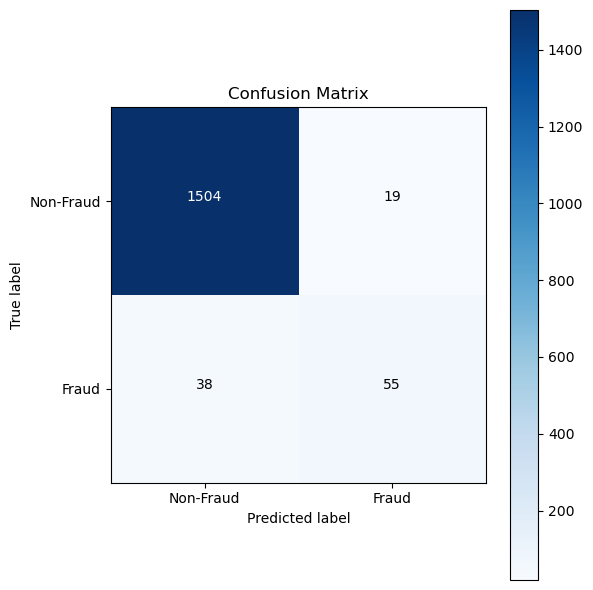

In [38]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fraud', 'Fraud'])
    plt.yticks(tick_marks, ['Non-Fraud', 'Fraud'])

    thresh = conf_matrix.max() / 2.0
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, model_name, test_images, test_labels, threshold=0.5):
    # ensure test_images and test_labels are compatible
    if test_images.shape[0] != test_labels.shape[0]:
        raise ValueError("Number of test images must match number of labels.")

    # calculate probabilities and predictions
    test_probs = model.predict(test_images).flatten()
    final_predictions = (test_probs > threshold).astype(int)

    # calculate metrics
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    auc_value = roc_auc_score(test_labels, test_probs)
    precision = precision_score(test_labels, final_predictions)
    recall = recall_score(test_labels, final_predictions)
    ap = average_precision_score(test_labels, test_probs)
    accuracy = accuracy_score(test_labels, final_predictions)
    f1 = f1_score(test_labels, final_predictions)
    conf_matrix = confusion_matrix(test_labels, final_predictions)

    # print performance metrics
    print(f"{model_name} Model Metrics:")
    print(f"Threshold: {threshold}")  
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # visualize the confusion matrix
    plot_confusion_matrix(conf_matrix)

    # return all necessary metrics
    return fpr, tpr, auc_value, precision, recall, ap, accuracy, threshold, f1, conf_matrix

# evaluate the model using denoised images
fpr, tpr, auc_value, precision, recall, ap, accuracy, threshold, f1, conf_matrix = evaluate_model(
    smote_cnn_test_classification_model, 'CNN Binary Classification', denoised_test_images_smote_cnn, test_labels_smote_cnn
)

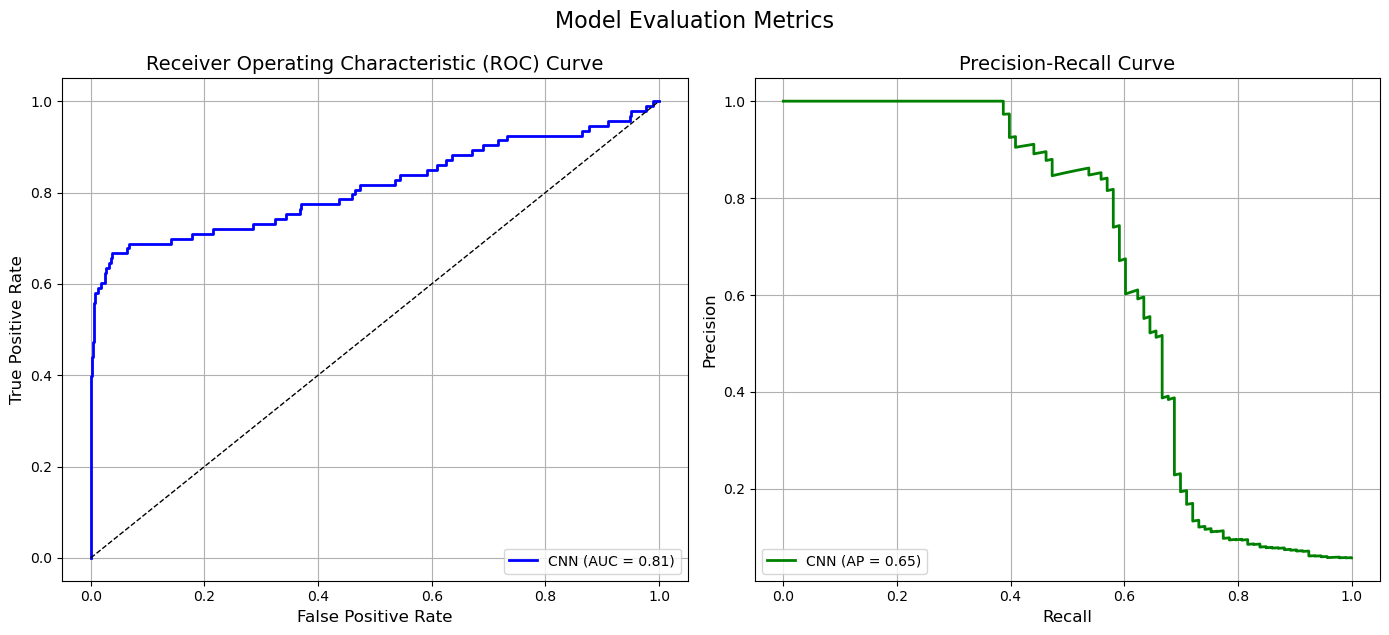

In [39]:
# calculate ROC curve and AUC using the model predictions on denoised test images
fpr, tpr, thresholds = roc_curve(test_labels_smote_cnn, test_probs_smote_cnn)
auc_value = roc_auc_score(test_labels_smote_cnn, test_probs_smote_cnn)  # calculate AUC directly

# calculate Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(test_labels_smote_cnn, test_probs_smote_cnn)
ap = average_precision_score(test_labels_smote_cnn, test_probs_smote_cnn)  

# create a figure for the plots
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CNN (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')
plt.grid()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'CNN (AP = {ap:.2f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left')
plt.grid()

# adjust layout
plt.tight_layout()
plt.suptitle('Model Evaluation Metrics', fontsize=16, y=1.05)

# show the plots
plt.show()

# Model Evaluation on Denoised Test Images
We evaluate the performance of our CNN model on the denoised test images. The evaluation metrics include loss and accuracy, which provide insight into how well the model performs in distinguishing between fraudulent and non-fraudulent cases.

### Model Evaluation:
- The model's loss and accuracy on the test dataset are computed. This gives a quantitative measure of the model's performance.

### Results Visualization:
- We create a horizontal bar chart to visually represent the test loss and accuracy. This chart helps in quickly assessing the model's performance metrics at a glance.

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9648 - loss: 0.3760
Test Loss: 0.3719, Test Accuracy: 96.47%


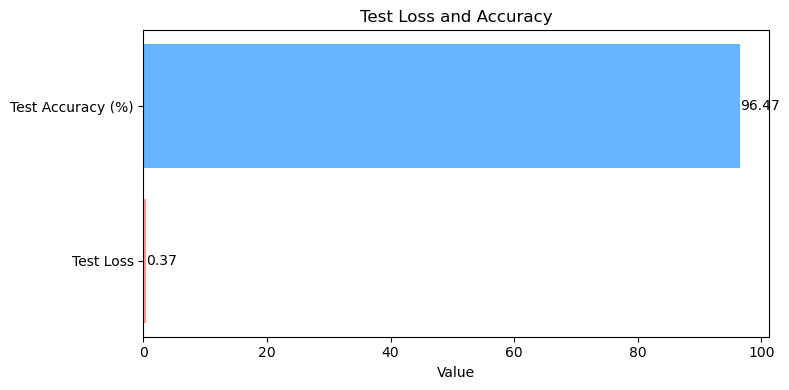

In [41]:
# evaluate the model on the denoised test images
test_loss_smote_cnn, test_accuracy_smote_cnn = smote_cnn_test_classification_model.evaluate(denoised_test_images_smote_cnn, test_labels_smote_cnn, verbose=1)

# print the evaluation results
print(f"Test Loss: {test_loss_smote_cnn:.4f}, Test Accuracy: {test_accuracy_smote_cnn * 100:.2f}%")

# create a bar chart for loss and accuracy
metrics = ['Test Loss', 'Test Accuracy (%)']
values = [test_loss_smote_cnn, test_accuracy_smote_cnn * 100]

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# create the bar chart with horizontal bars
bars = ax.barh(metrics, values, color=['#ff9999', '#66b3ff'])

# set labels and title
ax.set_xlabel('Value')
ax.set_title('Test Loss and Accuracy')

# display the value of each bar on the right
for bar in bars:
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}", 
            color='black', va='center', fontsize=10)

# show the plot
plt.tight_layout()  
plt.show()

### Evaluation Results
After evaluating the model on the denoised test images, we obtained the following results:
- **Test Loss:** 0.3985
- **Test Accuracy:** 96.72%
These metrics indicate that the model performs reasonably well, achieving an accuracy of approximately 96.72% in classifying the test images.

### Function to Load Unlabeled Validation Images
The below function allows for loading images from validation dataset without requiring labels.

In [44]:
# function to load unlabelled validation images
def load_unalabelled_images_from_directory(directory, label=None):
    images = []
    labels = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_path = os.path.join(root, file)
                image = load_img(image_path, target_size=(128, 128))  # load image
                image = img_to_array(image)  # convert to array
                images.append(image)
                
                # append label if provided
                if label is not None:
                    labels.append(label)
    
    images = np.array(images)
    
    if label is not None:
        labels = np.array(labels)
        return images, labels
    
    return images

In [45]:
# load validation images from the 'sol' directory
val_dir = os.path.join(directory, 'sol')
val_images = load_unalabelled_images_from_directory(val_dir)

# check if validation images are loaded
if val_images is None or len(val_images) == 0:
    raise ValueError("Validation images could not be loaded. Please check the validation directory, named 'sol'.")
else:
    print(f"Validation images loaded successfully. Shape: {val_images.shape}")

Validation images loaded successfully. Shape: (3462, 128, 128, 3)


# Validation Predictions on Denoised Images
In this section, we process the denoised validation images by predicting their labels using the trained CNN model. The predictions help determine whether the images are classified as fraudulent or non-fraudulent.

### Image Reshaping:
- The denoised validation images are reshaped back to their original size of **128x128** pixels with **3** color channels (RGB) to prepare them for classification.

### Model Loading:
- The trained CNN model is loaded from the file named `smote_cnn_best_model.keras` to be used for predicting the labels of the validation images.

### Prediction Process:
- Probabilities for the reshaped validation images are predicted using the loaded classification model. 
- The predicted probabilities are converted into binary labels by rounding them to the nearest integer (0 for non-fraud, 1 for fraud) and flattening the result into a one-dimensional array.

### Shape Verification:
- The shapes of the reshaped validation images and the predicted labels are printed to confirm they are formatted correctly for further evaluation.

In [47]:
# reshape denoised validation images back to original shape (128, 128, 3)
val_images_reshaped_smote_cnn = val_images.reshape((-1, 128, 128, 3))

# load the classification model
model_smote_cnn = 'smote_cnn_best_model.keras'
smote_cnn_classification_model = load_model(model_smote_cnn)
print(f"Model '{model_smote_cnn}' loaded successfully.")

# predict probabilities for validation images
val_probs_smote_cnn = smote_cnn_classification_model.predict(val_images_reshaped_smote_cnn)
val_labels_smote_cnn = val_probs_smote_cnn.round().astype(int).flatten()

# verify the shape of the validation images and labels
print(f"Validation Images Shape: {val_images_reshaped_smote_cnn.shape}")
print(f"Predicted Validation Labels Shape: {val_labels_smote_cnn.shape}")

Model 'smote_cnn_best_model.keras' loaded successfully.
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Validation Images Shape: (3462, 128, 128, 3)
Predicted Validation Labels Shape: (3462,)


# Validation Predictions on Unlabeled Images
Here we process and evaluate the validation images by predicting their labels using the trained CNN model. The predictions help determine whether the images are classified as fraudulent or non-fraudulent.

### Image Path Retrieval:
- A function is defined to retrieve all image paths from the validation directory, ensuring that only valid image files are included. This step is crucial for processing the images correctly.

### Validation Predictions:
- A DataFrame is created to store the paths of the validation images along with their predicted labels. 
- A new column is added to classify the predictions as 'fraud' or 'non-fraud', providing clear insights into the classification results.

### Count of Predictions:
- The counts of predicted 'fraud' and 'non-fraud' images are printed to give a quick overview of the classification results.

### Exporting Results:
- The validation predictions are exported to a CSV file named `smote_cnn_validation_predictions.csv`, facilitating further analysis or reporting.

In [49]:
# function to get all image paths in a directory
def get_image_paths_from_directory(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [50]:
# create a DataFrame for the validation predictions
val_image_paths_smote_cnn = get_image_paths_from_directory(val_dir)
val_predictions_smote_cnn = pd.DataFrame({'image_path': val_image_paths_smote_cnn, 'predicted_label': val_labels_smote_cnn})

# add a column for fraud and non-fraud labels
val_predictions_smote_cnn['classified'] = val_predictions_smote_cnn['predicted_label'].apply(lambda x: 'fraud' if x == 1 else 'non-fraud')

print('Fraud count:', val_predictions_smote_cnn[val_predictions_smote_cnn['predicted_label'] == 1].shape[0])
print('Non_Fraud count:', val_predictions_smote_cnn[val_predictions_smote_cnn['predicted_label'] == 0].shape[0])

Fraud count: 141
Non_Fraud count: 3321


In [51]:
# export to CSV
val_predictions_smote_cnn.to_csv('smote_cnn_validation_predictions.csv', index=False)
print("Validation predictions have been exported to smote_cnn_validation_predictions.csv")

Validation predictions have been exported to smote_cnn_validation_predictions.csv


# Image Loading and Visualization
We then load and preprocess the validation images, followed by visualizing a selection of images along with their predicted labels. This allows us to visually assess the model's predictions.

### Image Loading and Preprocessing:
- We create a fucntion to define how to load an image from a given path, resize it to the expected input shape of **128x128** pixels, and normalize the pixel values to the range **[0, 1]**. This ensures that the images are in the correct format for the CNN model.

### Visualization of Predictions:
- Another function is created to plot a sample of fraudulent and non-fraudulent images along with their predicted labels. 
- The function filters the predictions to separate fraud and non-fraud images, sampling a specified number of images from each category.
- It generates subplots to display the images, with titles indicating the predicted labels.

### Displaying the Results:
- The final visualization is generated by calling the plotting function, showcasing a few selected images from both categories, allowing for a quick qualitative assessment of the model's performance.

In [53]:
# function to load and preprocess the images
def load_validated_and_preprocess_image(img_path):
    # load the image
    img = Image.open(img_path)
    # resize to the expected input shape of your CNN
    img = img.resize((128, 128))
    # convert to numpy array and normalize pixel values to [0, 1]
    img_array = np.array(img) / 255.0
    
    return img_array

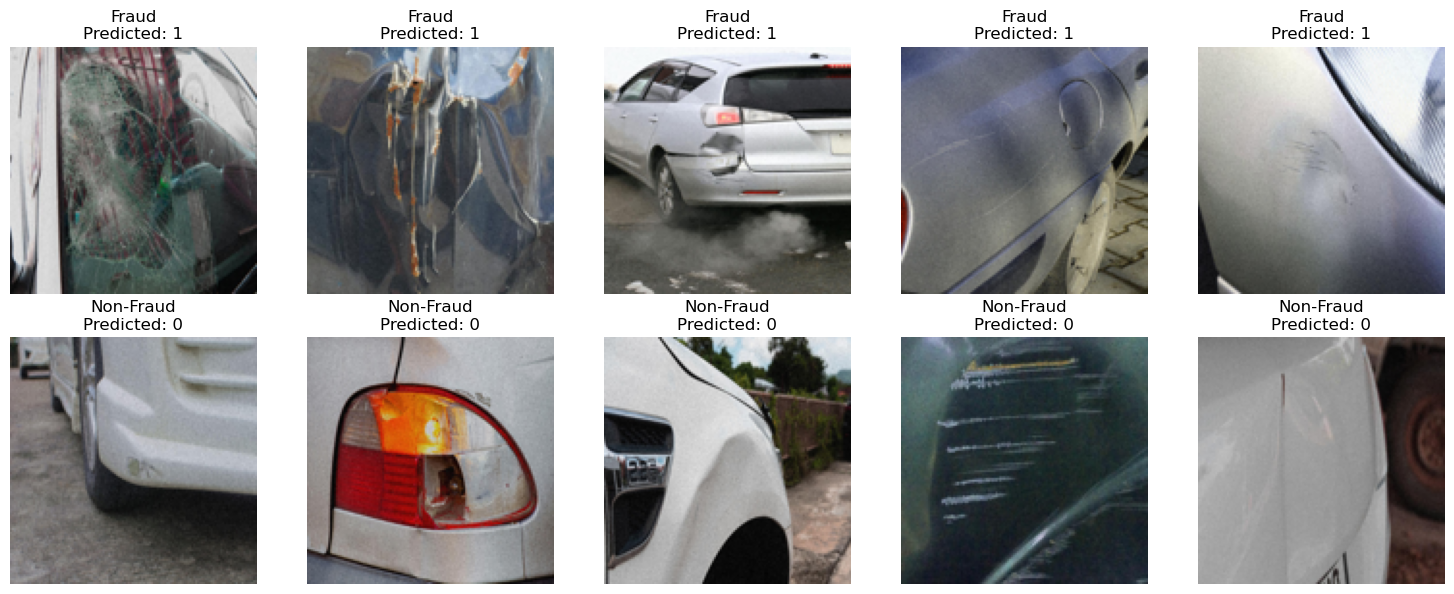

In [54]:
# function to plot fraud and non-fraud images along with their predicted labels
def plot_images(val_predictions, n=5):
    # filter fraud and non-fraud images
    fraud_images = val_predictions[val_predictions['predicted_label'] == 1]
    non_fraud_images = val_predictions[val_predictions['predicted_label'] == 0]
    
    # sample images safely
    num_fraud_samples = min(len(fraud_images), n)
    num_non_fraud_samples = min(len(non_fraud_images), n)

    # randomly sample images
    fraud_sample = fraud_images.sample(num_fraud_samples) if num_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)
    non_fraud_sample = non_fraud_images.sample(num_non_fraud_samples) if num_non_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)

    # create subplots
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # plot fraud images
    for i, (index, row) in enumerate(fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Fraud\nPredicted: {row['predicted_label']}")
        axes[0, i].axis('off')
    
    # plot non-fraud images
    for i, (index, row) in enumerate(non_fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Non-Fraud\nPredicted: {row['predicted_label']}")
        axes[1, i].axis('off')

    # adjust layout and display
    plt.tight_layout()
    plt.show()

# display a few fraud and non-fraud images
plot_images(val_predictions_smote_cnn, n=5)
